In [1]:
palette = ['#3B8EA1', '#B84D4A', '#6F5B9A', '#B59F8E', '#D96B9A', '#A3A3A3', '#D88F3B', '#4C9F4A']
from pathlib import Path
clinical_datasets = Path("..") / "data" / "other_data" / "clinical_datasets"
variant_scores = Path("..") / "data" / "processed_scores"
figure = Path("..") / "figures"
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import roc_curve, auc
from adjustText import adjust_text
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import mannwhitneyu
from scipy.stats import spearmanr
from scipy.optimize import curve_fit
from scipy.stats import linregress
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import ttest_ind 
from adjustText import adjust_text
import matplotlib.lines as mlines
import seaborn as sns
import pandas as pd
import numpy as np
methods = ["SuSPect","SNAP2","SIFT","Grantham","BLOSUM62","PonP2","SIFT4G","Polyphen2_HumDiv","Polyphen2_HumVar","LRT","MutationTaster",
           "MutationAssessor","FATHMM","PROVEAN","VEST4","MetaSVM","MetaLR","M-CAP","REVEL","MutPred","MVP","MPC","PrimateAI","DEOGEN2",
           "CADD","DANN","fathmm-MKL","fathmm-XF","Eigen","GenoCanyon","fitCons","GERP++","phyloP","phastCons","SiPhy","MetaRNN",
           "BayesDel","ClinPred","LIST-S2","LINSIGHT","EVmutation_epistatic","EVmutation_independent","DeepSequence","VARITY_R",
           "VARITY_ER","VESPAl","mutationTCN","ESM-1v","Envision","CPT","DeepSAV","sequence_unet","NetDiseaseSNP","ESM-1b","MISTIC",
           "CAPICE","DeMaSk","gMVP","InMeRF","UNEECON","SNPred","AlphaMissense","LASSIE","ESCOTT","iGEMME","MutScore","GEMME","SPRI",
           "MutFormer","popEVE","Tranception","EVE","AlphScore","SIGMA","BayesDel_noAF","CONDEL","Maverick_benign","Maverick_dominant",
           "Maverick_recesive","PhD-SNPg","PHACTboost","PHACT","CADD_1.7","ESM2",
           "Low Exp. (D)","High Exp. (D)","Est. Enzyme Activities","Low Exp. (C)","High Exp. (C)"]

In [2]:
def csv_read(variant_scores = variant_scores, clinical_datasets = clinical_datasets):
    variants = pd.read_csv(f"{clinical_datasets}\\ADSL_SNVs.csv")
    low_dox = pd.read_csv(f"{variant_scores}\\lowADSL_dox+_fitness_score.csv")[["variant", "fitness_score"]].rename(columns = {"fitness_score":
                                                                                                        "Low Exp. (D)"})
    df_one = variants.merge(low_dox, on = "variant", how = "left")
    high_dox = pd.read_csv(f"{variant_scores}\\highADSL_dox+_fitness_score.csv")[["variant", "fitness_score"]].rename(columns = {"fitness_score":
                                                                                                                  "High Exp. (D)"})
    df_two = variants.merge(high_dox, on = "variant", how = "left")
    df_dox = df_one.merge(df_two, on = "variant")
    low_con = pd.read_csv(f"{variant_scores}\\lowADSL_dox-_fitness_score.csv")[["variant", "fitness_score"]].rename(columns = {"fitness_score":
                                                                                                                  "Low Exp. (C)"})
    df_three = variants.merge(low_con, on = "variant", how = "left")
    high_con = pd.read_csv(f"{variant_scores}\\highADSL_dox-_fitness_score.csv")[["variant", "fitness_score"]].rename(columns = {"fitness_score":
                                                                                                                  "High Exp. (C)"})
    df_four = variants.merge(high_con, on = "variant", how = "left")
    df_con = df_three.merge(df_four, on = "variant")
    dms = df_dox.merge(df_con, on = "variant")
    est = pd.read_csv(f"{variant_scores}\\ADSL_Est_Ei.csv")[["variant", "Est_Ei"]].rename(columns = {"Est_Ei":
                                                                                                   "Est. Enzyme Activities"})
    dms = dms.merge(est, on = "variant", how = "left")
    prediction = pd.read_csv(f"{clinical_datasets}\\P30566_29112024.csv")
    df = dms.merge(prediction, on = "variant", how = "left")
    return df, dms, prediction

In [3]:
def roc_auc_calculate(df, prediction, dataset):
    df = df[["variant", dataset, prediction]].dropna()
    benign = len(df[df[dataset] == 1])
    pathogenic = len(df[df[dataset] == 0])

    y_true = df[dataset]
    y_pred = df[prediction]
    
    try:
        roc_auc = roc_auc_score(y_true, y_pred, average="samples")
    except ValueError as e:
        return None

    if roc_auc < 0.5:
        roc_auc = 1 - roc_auc

    output = pd.DataFrame({
        "method": [prediction],
        "auc": [roc_auc],
        "benign": [benign],
        "pathogenic": [pathogenic]
    })
    return output

In [11]:
def auc_list(df, methods, dataset, clinical_datasets=clinical_datasets):
    print(f"num. of predictors: {len(methods)}")
    
    # Only calculate once per predictor
    auc_results = []
    for predictor in methods:
        result = roc_auc_calculate(df, predictor, dataset)
        if result is not None:
            auc_results.append(result)

    # Create list of dictionaries for each result
    auc_data = [
        {
            "method": result["method"][0],
            "roc-auc": result["auc"][0],
            "benign": result["benign"][0],
            "pathogenic": result["pathogenic"][0], 
            "total": result["benign"][0] + result["pathogenic"][0]
        }
        for result in auc_results
    ]

    output = pd.DataFrame(auc_data)

    # Merge with predictor type info
    vep_type = pd.read_csv(f"{clinical_datasets}\\VEP_criteria.csv")
    vep_type = vep_type[vep_type["Coverage"]==True]
    vep_type = vep_type[vep_type["benchmark"]==True]
    output = vep_type.merge(output, on="method")

    # Sort by AUC
    output = output.sort_values(by='roc-auc', ascending=False).reset_index(drop=True)
    return output

In [12]:
df, dms, prediction = csv_read()
rep_variants = pd.read_csv(f"{clinical_datasets}\\ADSL_reported_variants_filtered.csv")
dfOne = rep_variants.merge(df, on = "variant")
dfTwo = dfOne.copy()

Text(0, 0.5, 'Enzyme Activity\n(Estimated)')

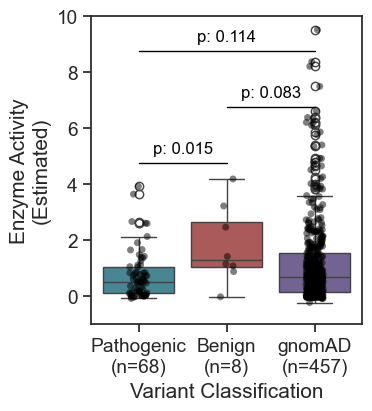

In [13]:
dfOne = dfOne[["variant","variant_type","classification","source","Est. Enzyme Activities"]]
sns.set(font_scale=1.25, rc={'figure.figsize': (3.5, 4)}, style="ticks")
sns.boxplot(data=dfOne,x="classification", y="Est. Enzyme Activities", hue = "classification", 
            order=["pathogenic", "benign", "putatively benign"], palette=palette[0:3],)
sns.stripplot(data=dfOne, x="classification", y="Est. Enzyme Activities", hue="classification", 
              order=["pathogenic", "benign", "putatively benign"], palette=["black"] * 3, alpha=0.5, jitter=True)
plt.ylim(-1, 10)

plt.xlabel("Variant Classification")
# Perform t-test
benign = dfOne[dfOne["classification"]=="benign"]["Est. Enzyme Activities"].dropna()
pathogenic = dfOne[dfOne["classification"]=="pathogenic"]["Est. Enzyme Activities"].dropna()
gnomad = dfOne[dfOne["classification"]=="putatively benign"]["Est. Enzyme Activities"].dropna()
plt.xticks([0,1,2], ["Pathogenic" + "\n" + f"(n={len(pathogenic)})", 
                     "Benign" + "\n" + f"(n={len(benign)})", 
                     "gnomAD" + "\n" + f"(n={len(gnomad)})"])

stat_bp, benign_pathogenic = mannwhitneyu(benign, pathogenic)
stat_pg, pathogenic_gnomad = mannwhitneyu(pathogenic, gnomad)
stat_bg, benign_gnomad = mannwhitneyu(benign, gnomad)
plt.text(0.5, 5, f"p: {round(benign_pathogenic,3)}", ha="center", va="bottom", fontsize=12, color="black")
plt.plot([0, 1], [4.75, 4.75], color='black', lw=1)
plt.text(1, 9, f"p: {round(pathogenic_gnomad,3)}", ha="center", va="bottom", fontsize=12, color="black")
plt.plot([0, 2], [8.75, 8.75], color='black', lw=1)
plt.text(1.5, 7, f"p: {round(benign_gnomad,3)}", ha="center", va="bottom", fontsize=12, color="black")
plt.plot([1, 2], [6.75, 6.75], color='black', lw=1)
plt.ylabel("Enzyme Activity\n(Estimated)")
#plt.savefig(f"{figure}figure.svg", format = "svg", bbox_inches='tight')
#plt.close()

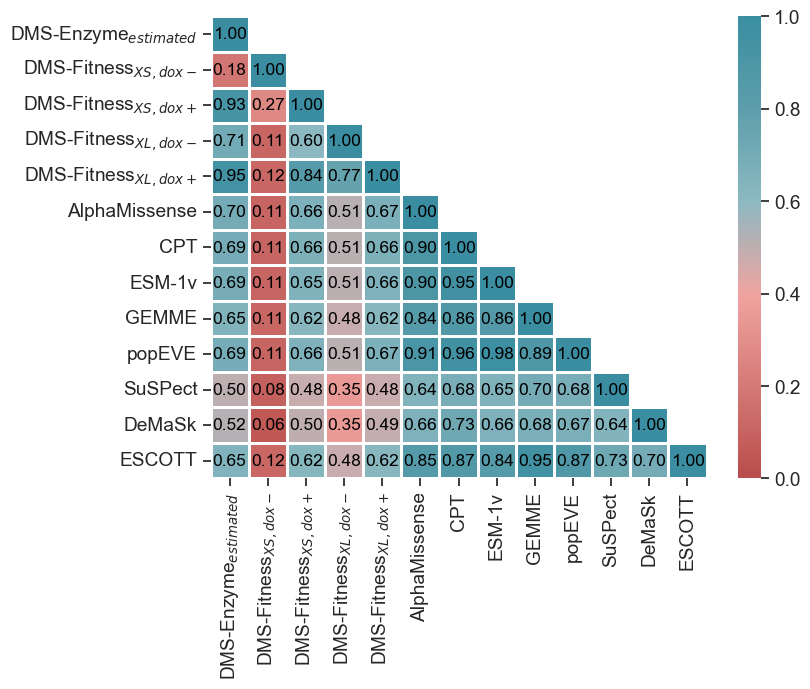

In [14]:
corr = df[["Est. Enzyme Activities", "Low Exp. (C)", "Low Exp. (D)", "High Exp. (C)", "High Exp. (D)",
           "AlphaMissense","CPT", "ESM-1v","GEMME","popEVE", "SuSPect", "DeMaSk", "ESCOTT"]].dropna()
corr = corr.rename(columns = {"Est. Enzyme Activities":"DMS-Enzyme$_{estimated}$", 
                       "Low Exp. (D)":"DMS-Fitness$_{XS,dox+}$", 
                       "Low Exp. (C)":"DMS-Fitness$_{XS,dox-}$",
                       "High Exp. (D)":"DMS-Fitness$_{XL,dox+}$", 
                       "High Exp. (C)":"DMS-Fitness$_{XL,dox-}$"})
corr_matrix = corr.corr(method = "spearman").abs()
mask = np.zeros_like(corr_matrix)  
mask[np.triu_indices_from(mask, k=1)] = True
colors = ["#B84D4A", "#D57A77", "#F0A4A0", "#8CB9C1", "#5D9EAB", "#3B8EA1"]
cmap = LinearSegmentedColormap.from_list("Custom", colors)
sns.set(font_scale=1.25, font="arial", rc={'figure.figsize': (8, 6)}, style="ticks")
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", annot_kws={"size": 12.5, 'font': 'Arial', 'color': 'black'},
                 cmap=cmap, mask=mask, linewidths=0.75, vmin=0, vmax=1)
#plt.savefig(f"{figure}figure.svg", format = "svg", bbox_inches='tight')
#plt.close()

In [15]:
auc_scores = auc_list(df = dfTwo, methods = methods, dataset = "putatively_benign") #putatively_benign, benign
auc_scores.loc[auc_scores["method"] == "Low Exp. (D)", "method"] = "DMS-Fitness$_{XS,dox+}$"
auc_scores.loc[auc_scores["method"] == "Low Exp. (C)", "method"] = "DMS-Fitness$_{XS,dox-}$"
auc_scores.loc[auc_scores["method"] == "High Exp. (D)", "method"] = "DMS-Fitness$_{XL,dox+}$"
auc_scores.loc[auc_scores["method"] == "High Exp. (C)", "method"] = "DMS-Fitness$_{XL,dox-}$"
auc_scores.loc[auc_scores["method"] == "Est. Enzyme Activities", "method"] = "DMS-Enzyme$_{estimated}$"
print(f"Methods ANALYZED: {len(auc_scores)}")

num. of predictors: 89
Methods ANALYZED: 75


In [17]:
auc_scores[auc_scores["method"]=="DMS-Fitness$_{XS,dox+}$"]

,method,type,benchmark,Coverage,roc-auc,benign,pathogenic,total
9,"DMS-Fitness$_{XS,dox+}$",Deep Mutational Scanning,True,True,0.618051,455,61,516


Text(60, 0.75, 'DMS-Fitness$_{XS,\\ dox+}$: 0.62')

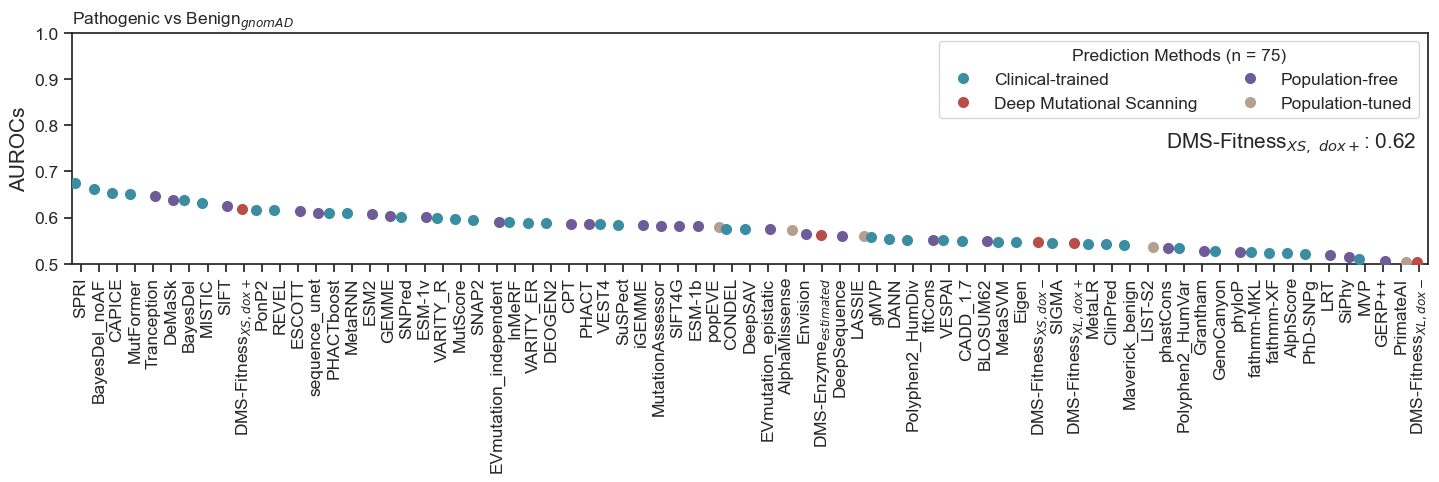

In [18]:
sns.set(font_scale=1.25, rc={'figure.figsize': (17.5, 3)}, style="ticks")
ax = sns.stripplot( data=auc_scores, x="method", y="roc-auc", hue="type", palette=palette[0:4],
                    hue_order=["Clinical-trained", "Deep Mutational Scanning", "Population-free", "Population-tuned"],
                    size=8, jitter=True, dodge=True)

plt.xticks(rotation=90, fontsize=12.5)
plt.ylim(0.5, 1)
plt.yticks(fontsize=12.5)
plt.ylabel("AUROCs")
plt.xlabel("")
plt.title("Pathogenic vs Benign$_{gnomAD}$", loc="left", fontsize=12.5)
legend = plt.legend(title="Prediction Methods (n = 75)", fontsize=12.5, ncol=2, loc='upper right')
legend.get_title().set_fontsize(12.5)
text = auc_scores[auc_scores["method"] == "DMS-Fitness$_{XS,dox+}$"]["roc-auc"].values[0]
plt.text(60, 0.75, f"DMS-Fitness$_{{XS,\\ dox+}}$: {round(text, 2)}")
#plt.savefig(f"{figure}figure.svg", format="svg", bbox_inches="tight")
#plt.close()

In [19]:
df_patient_enz = pd.read_csv(f"{clinical_datasets}\\ADSL_patient_enzyme_activities.csv")
couple = ["saicar","high_%"]
data = df_patient_enz[[couple[0], couple[1]]].dropna()
corr, p_value = spearmanr(data[couple[0]], data[couple[1]])
#------
print("Spearman correlation:", round(corr,4))
print("p-value:", round(p_value,4))

Spearman correlation: 0.4156
p-value: 0.1094


In [20]:
patient_corr = pd.DataFrame({
    "substrate": ["samp", "samp", "samp", "saicar", "saicar", "saicar"],
    "dataset": ["Ei_%", "low_%", "high_%", "Ei_%", "low_%", "high_%"],
    "spearman": [0.4402, 0.5408, 0.2661, 0.5615, 0.787, 0.4156],
    "p_value": [0.077, 0.025, 0.3019, 0.0236, 0.0003, 0.1094]
})

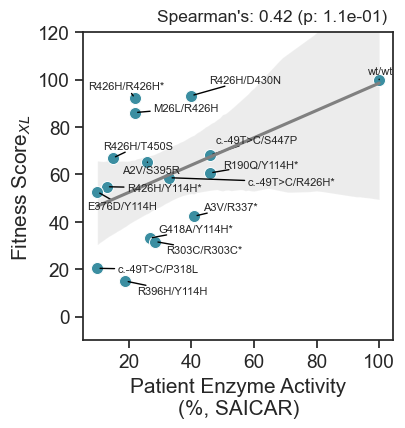

In [21]:
# Extract Spearman & p-value
sample = ["saicar", "high_%"]
correlations = patient_corr.loc[
    (patient_corr["substrate"] == sample[0]) & (patient_corr["dataset"] == sample[1]),["spearman", "p_value"]].values.flatten().tolist()
sns.set(font_scale=1.25, font="arial", rc={'figure.figsize': (4, 4)}, style="ticks")
plot = df_patient_enz[["sample",sample[0],sample[1]]].dropna()
sns.regplot(data=plot, x=sample[0], y=sample[1], scatter=False, color="grey")
sns.scatterplot(data=plot, x=sample[0], y=sample[1], s=75, color=palette[0])
# Annotate variants
annotated_variants = {}
texts = []
for index, row in plot[::-1].iterrows():
    variant = row["sample"]
    if variant not in annotated_variants:
        texts.append(plt.text(row[sample[0]], row[sample[1]], variant, fontsize=8))
        annotated_variants[variant] = True
# Adjust text
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'), expand=(1.5, 1.5))
# Regression legend (if needed)
regression_line = mlines.Line2D([], [], color="grey", linewidth=1, linestyle=":")

# Spearman annotation
plt.annotate(f"Spearman's: {correlations[0]:.2f} "
             f"(p: {correlations[1]:.1e})",
             xy=(0.98, 1.075), xycoords='axes fraction',
             ha='right', va='top', fontsize=12.5)

#plt.ylim(-10,110) #Ei
#plt.ylabel(r"DMS-BiPS$_{\text{Enzyme, \%}}$")

plt.ylim(-10,120)
if sample[1]=="low_%":
    plt.ylabel("Fitness Score$_{XS}$")
if sample[1]=="high_%":
    plt.ylabel("Fitness Score$_{XL}$")
if sample[0]=="samp":
    plt.xlabel("Recombinant Enzyme Activity" + "\n" "(%, SAMP)")
if sample[0]=="saicar":
    plt.xlabel("Patient Enzyme Activity" + "\n" "(%, SAICAR)")
#plt.savefig(f"{figure}figure.svg", format = "svg", bbox_inches='tight', transparent=True)
#plt.close()

In [22]:
rep_patient = pd.read_csv(f"{clinical_datasets}\\ADSL_unique_genotypes.csv", encoding="latin1")
dfThree = rep_patient.merge(df[["variant", "Low Exp. (D)", "High Exp. (D)"]], left_on = "allele_one", right_on = "variant")
dfFour = dfThree.merge(df[["variant", "Low Exp. (D)", "High Exp. (D)"]], left_on = "allele_two", right_on = "variant")
#dfFive = pathogenicity_score(dfFour, methods)
#dfFive["variant"]=dfFive["case_id"]

In [23]:
def pathogenicity_score(df, pred):
    # Iterate over each column pair defined in pred
    for p in pred:
        # Calculate only if both columns have non-NaN values
        df[p] = df.apply(lambda row: row[f"{p}_x"] + row[f"{p}_y"] 
                         if pd.notna(row[f"{p}_x"]) and pd.notna(row[f"{p}_y"]) 
                         else np.nan, axis=1)
    columns_to_drop = [f"{p}_x" for p in pred] + [f"{p}_y" for p in pred] + ["variant_x", "variant_y"]
    df = df.drop(columns=columns_to_drop)
    return df[["case_id", "allele_one", "allele_two", "occurance", "genotype", "phenotype", "biallelic"] + methods]

In [24]:
rep_patient = pd.read_csv(f"{clinical_datasets}\\ADSL_unique_genotypes.csv", encoding="latin1")
dfThree = rep_patient.merge(df, left_on = "allele_one", right_on = "variant")
dfFour = dfThree.merge(df, left_on = "allele_two", right_on = "variant")
dfFive = pathogenicity_score(dfFour, methods)
dfFive["variant"]=dfFive["case_id"]

(-1.0, 10.0)

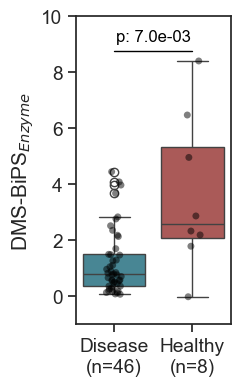

In [25]:
dfSix = dfFive[["case_id","allele_one","allele_two","occurance","genotype","phenotype","biallelic","Est. Enzyme Activities"]]
sns.set(font_scale=1.25, rc={'figure.figsize': (2, 4)}, style="ticks")
sns.boxplot(data=dfSix,x="phenotype", y="Est. Enzyme Activities", hue = "phenotype", 
            order=["ADSL_deficiency", "Control"], palette=palette[0:2])
sns.stripplot(data=dfSix, x="phenotype", y="Est. Enzyme Activities", hue="phenotype", 
              order=["ADSL_deficiency", "Control"], palette=["black"] * 2, alpha=0.5, jitter=True)
# Perform t-test
adsl = dfSix[dfSix["phenotype"]=="ADSL_deficiency"]["Est. Enzyme Activities"].dropna()
control = dfSix[dfSix["phenotype"]=="Control"]["Est. Enzyme Activities"].dropna()
stat, adsl_control = mannwhitneyu(adsl, control)
plt.text(0.5, 9, f"p: {adsl_control:.1e}", ha="center", va="bottom", fontsize=12, color="black")
plt.plot([0, 1], [8.75, 8.75], color='black', lw=1)
plt.ylabel("DMS-BiPS$_{Enzyme}$")
plt.xticks([0,1], ["Disease" + "\n"+ f"(n={len(adsl)})", "Healthy" + "\n"+ f"(n={len(control)})"])
plt.xlabel("")
plt.ylim(-1, 10)
#plt.savefig(f"{figure}figure.svg", format = "svg", bbox_inches='tight')
#plt.close()

In [26]:
auc_scores = auc_list(df = dfFive, methods = methods, dataset = "biallelic") #biallelic
auc_scores.loc[auc_scores["method"] == "Low Exp. (D)", "method"] = "DMS-BiPS$_{XS,dox+}$"
auc_scores.loc[auc_scores["method"] == "Low Exp. (C)", "method"] = "DMS-BiPS$_{XS,dox-}$"
auc_scores.loc[auc_scores["method"] == "High Exp. (D)", "method"] = "DMS-BiPS$_{XL,dox+}$"
auc_scores.loc[auc_scores["method"] == "High Exp. (C)", "method"] = "DMS-BiPS$_{XL,dox-}$"
auc_scores.loc[auc_scores["method"] == "Est. Enzyme Activities", "method"] = "DMS-BiPS$_{Enzyme}$"
print(f"Methods ANALYZED: {len(auc_scores)}")

num. of predictors: 89
Methods ANALYZED: 75


In [27]:
auc_scores[auc_scores["method"]=="DMS-BiPS$_{XS,dox+}$"]

,method,type,benchmark,Coverage,roc-auc,benign,pathogenic,total
1,"DMS-BiPS$_{XS,dox+}$",Deep Mutational Scanning,True,True,0.858974,8,39,47


Text(60, 0.75, 'DMS-BiPS$_{XS,dox+}$: 0.86')

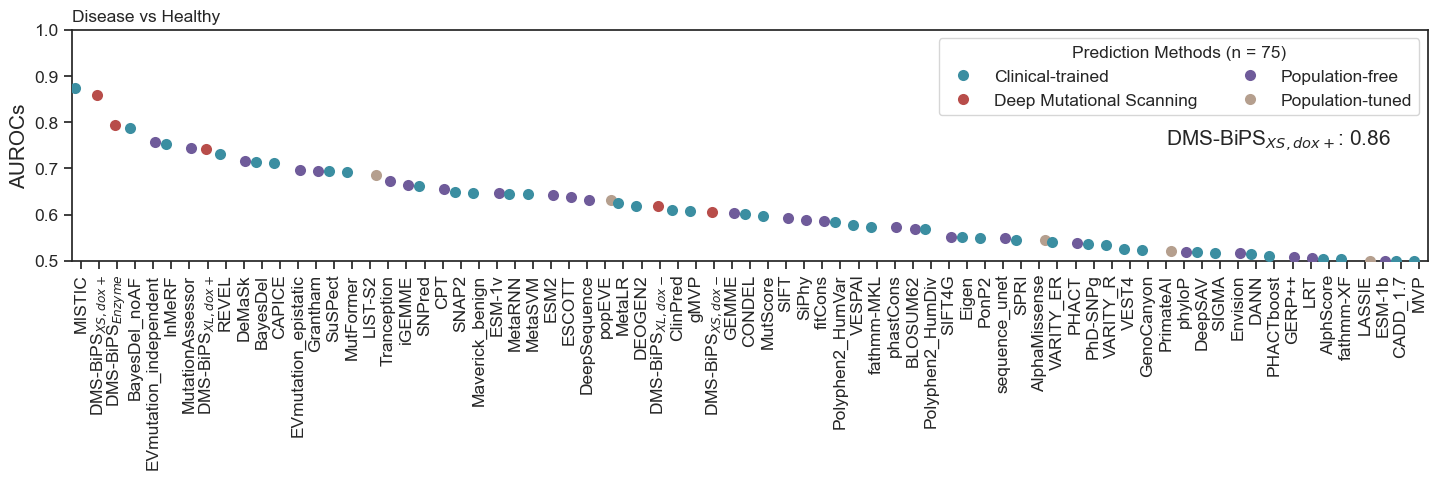

In [28]:
sns.set(font_scale=1.25, rc={'figure.figsize': (17.5, 3)}, style="ticks")
ax = sns.stripplot( data=auc_scores, x="method", y="roc-auc", hue="type", palette=palette[0:4],
                    hue_order=["Clinical-trained", "Deep Mutational Scanning", "Population-free", "Population-tuned"],
                    size=8, jitter=True, dodge=True)

plt.xticks(rotation=90, fontsize = 12.5)
plt.ylim(0.5,1)
plt.yticks(fontsize = 12.5)
legend = plt.legend(title="Prediction Methods (n = 75)", fontsize=12.5, ncol=2, loc='upper right')
legend.get_title().set_fontsize(12.5)
plt.ylabel("AUROCs")
plt.title("Disease vs Healthy", loc = "left", fontsize = 12.5)
plt.xlabel("")
text = auc_scores[auc_scores["method"] == "DMS-BiPS$_{XS,dox+}$"]["roc-auc"].values[0]
plt.text(60, 0.75, rf"DMS-BiPS$_{{XS,dox+}}$: {round(text, 2)}")
#plt.savefig(f"{figure}figure.svg", format="svg", bbox_inches="tight")
#plt.close()